# Data and Libraries

In [6]:
import pandas as pd
import pickle
import time
import random
import matplotlib.pyplot as plt
import numpy as np

DATA_PATH = ""
df = pd.read_json(DATA_PATH+"train.json")
test_df = pd.read_json(DATA_PATH+"test.json")
df_label = pd.read_csv(DATA_PATH+"train_label.csv")

categories_label = pd.read_csv("categories_string.csv")

# Cleaning

The only cleaning transformation applied here is that we `lower` the data so that all words are lower case. 
Hence `research`and `Research` will be considered as similar word.

You might want to look at other cleaning step such that removing stopwords, stemming words, etc.

In [7]:
df["description_lower"] = [x.lower() for x in df.description]
df.drop('description',axis=1,inplace=True)
df['Category'] = df_label['Category'].values
df['job'] = categories_label.loc[ df['Category'].values,'0'].values
df.head()

,Id,gender,description_lower,Category,job
0,0,F,she is also a ronald d. asmus policy entrepre...,19,professor
1,1,M,he is a member of the aicpa and wicpa. brent ...,9,accountant
10,8,F,her teachings get straight to the heart of ta...,19,professor
100,80,F,"she founded couples therapy inc, where she pr...",24,architect
1000,780,M,he is the head of the christian doppler labor...,24,architect


In [12]:
df.loc[df['job']=='professor','description_lower'].values[1]

' her teachings get straight to the heart of tantric buddhism and ayurvedic medicine for finding sanity and wisdom within every experience of life. also known as “tröma rinpoche”, she is buddhist teacher, humanitarian and author who founded of the school of yogic buddhism and the yogic medicine institute.'

In [37]:
test_df["description_lower"] = [x.lower() for x in test_df.description]
test_df.drop('description',axis=1,inplace=True)
test_df.reset_index(drop=True,inplace=True)
test_df.head()

,Id,gender,description_lower
0,19974,F,she received her bs in nursing from the unive...
1,19975,F,she studied medicine at the university of nev...
2,1985,M,he teaches undergraduate and graduate courses...
3,1986,M,he teaches in the carleton university english...
4,19976,M,"but, get this, he’s at a silicon valley hospi..."


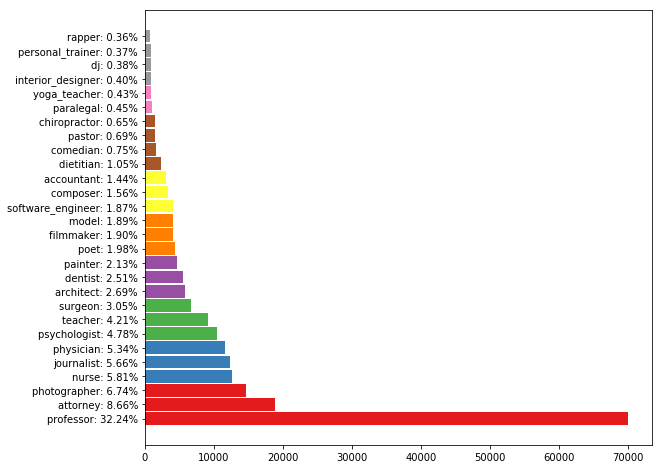

In [38]:
NUM_CATEGORIES = 28
CMAP = plt.get_cmap("Set1",NUM_CATEGORIES)
COLOR = [CMAP(k) for k in range(NUM_CATEGORIES)]


data_count = df['Category'].astype(int).value_counts()
#Rename index to add percentage
new_index = [categories_label['0'][k]+ ": %.2f%%" %(v*100/len(df)) for k,v in data_count.iteritems()]

fig=plt.figure(figsize= (20,8))
ax = fig.add_subplot(1,2,1)
ax.barh(range(NUM_CATEGORIES), data_count.values, 0.9, color = COLOR, tick_label = new_index)
plt.show()

## Indifferenciation :

Firstly, we will replace all words like he-she-her-his by their male equivalent : "he-he-his-his".
By doing this we will conserve the meaning of the sentences and decorrelate the job from the gender (partially).
It will also help decorrelate first names from gender, but not from proffessions.
In order to do this, we created an excel file that will make the correspondance between the word to be replaced and its target word. A sort of "converter".

This is why in a second time, we will replace every first name we found by an unique first or word, it does not matter.
We are using this file to detect every first name and replace it :


https://www.nrscotland.gov.uk/statistics-and-data/statistics/statistics-by-theme/vital-events/names/babies-first-names/full-lists-of-babies-first-names-2010-to-2014




### Removing first names :

In [39]:
english_names = pd.read_excel("list_of_english_names.xlsx")
male_names = pd.Series.dropna(english_names.loc[6:450,"Unnamed: 1"]).values
female_names = pd.Series.dropna(english_names.loc[6:450,"Unnamed: 5"]).values
names = list(male_names) + list(female_names)
names = [name.lower() for name in names]
for name in names :
    if len(name)<3 :
        names.remove(name)
random.shuffle(names)
print('5 first names : ', names[:5],f'\n{len(names)} first names in total.')

male_default_name = 'BOY'
female_default_name = 'GIRL'

5 first names :  ['ariana', 'jade', 'mairi', 'jayden', 'joanna'] 
890 first names in total.


In [40]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
STOPWORDS = ENGLISH_STOP_WORDS
def clean_text(text):
    #de-genderization :
    text = text.replace("she",'he')
    text = text.replace("her",'his')
    text = text.replace("herself",'himself')
    text = text.replace("wife",'husband')
    text = text.replace("ms",'mr')
    
    #removing numbers, special caracters :
    text = ''.join([i for i in text if ( not i.isdigit() and i.isalpha()) or i.isspace()]) 
    
    #removing stopwords :
    global STOPWORDS
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    
    #removing names :
    global names
    
    splitted_text = text.split()
    corrected_text = ''
    for word in splitted_text :
        if word in names :
            corrected_text += ' '
        else :
            corrected_text += word +' '
    return text

In [43]:
t0 = time.time()
test_df['description final'] = test_df['description_lower'].apply(clean_text).values
print("done in", time.time() - t0,'seconds')
test_df.head()

done in 29.2435040473938 seconds


,Id,gender,description_lower,description final
0,19974,F,she received her bs in nursing from the unive...,received bs nursing university vermont burling...
1,19975,F,she studied medicine at the university of nev...,studied medicine university nevada school medi...
2,1985,M,he teaches undergraduate and graduate courses...,teaches undergraduate graduate courses educati...
3,1986,M,he teaches in the carleton university english...,teaches carleton university english department...
4,19976,M,"but, get this, he’s at a silicon valley hospi...",hes silicon valley hospital founded silicon va...


## Applying this to our train df :

In [44]:
t0 = time.time()
df['description final'] = df['description_lower'].apply(clean_text).values
print("done in", time.time() - t0, 'seconds')
df.head()

done in 109.36709237098694 seconds


,Id,gender,description_lower,Category,job,description final
0,0,F,she is also a ronald d. asmus policy entrepre...,19,professor,ronald d asmus policy entrepreneur fellow germ...
1,1,M,he is a member of the aicpa and wicpa. brent ...,9,accountant,member aicpa wicpa brent graduated university ...
10,8,F,her teachings get straight to the heart of ta...,19,professor,teachings straight heart tantric buddhism ayur...
100,80,F,"she founded couples therapy inc, where she pr...",24,architect,founded couples thisapy whise practices intern...
1000,780,M,he is the head of the christian doppler labor...,24,architect,head christian doppler laboratory monitoring e...


In [45]:
df.to_excel("preprocessed_train.xlsx")
test_df.to_excel("preprocessed_test.xlsx")

## Loading pre-processed data :

In [46]:
df = pd.read_excel("preprocessed_train.xlsx")
test_df = pd.read_excel("preprocessed_test.xlsx")

### Splitting Train dataset in two :

In [53]:
from sklearn.model_selection import train_test_split

df_train, df_validation = train_test_split(df, test_size=.2,shuffle=True,random_state= 42)

### Text vectorization :

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
transformer = TfidfVectorizer(stop_words=None, max_features=100)

X_train = transformer.fit_transform(df_train['description_lower'].values).toarray()
Y_train = df_train['Category'].values

X_validation  = transformer.transform(df_validation['description_lower'].values).toarray()
Y_validation = df_validation['Category'].values

In [55]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.metrics import CategoricalAccuracy

In [68]:
NUM_CATEGORIES = len(categories_label['0'])

activation_function = 'tanh'
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1],activation=activation_function))
model.add(Dense(128,activation=activation_function))
model.add(Dense(X_train.shape[1],activation=activation_function))

model.add(Dense(NUM_CATEGORIES,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=[CategoricalAccuracy()])

In [69]:
from keras.utils import to_categorical
y_train_categorical = to_categorical(Y_train)
y_validation_categorical = to_categorical(Y_validation)

model.fit(X_train,y_train_categorical, epochs = 5, validation_data = (X_validation,y_validation_categorical))

Epoch 1/5
5430/5430 [==============================] - 7s 1ms/step - loss: 2.6236 - categorical_accuracy: 0.3228 - val_loss: 2.6293 - val_categorical_accuracy: 0.3199
Epoch 2/5
 819/5430 [===>..........................] - ETA: 4s - loss: 2.6147 - categorical_accuracy: 0.3230

KeyboardInterrupt: 

In [282]:
y_train_categorical = to_categorical(Y_train)
y_validation_categorical = to_categorical(Y_validation)

model.fit(X_train,y_train_categorical, epochs = 5, validation_data = (X_validation,y_validation_categorical),batch_size=10)

Epoch 1/5
17376/17376 [==============================] - ETA: 0s - loss: 2.6240 - accuracy: 0.3229

KeyboardInterrupt: 

## Macro F1 Score : on 20% of the training set (our validation set)

In [32]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_validation)
print(f1_score(Y_validation, y_pred, average='macro'))

0.017537928494821813


C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Measuring the Fairness score :

In [33]:
X_test  = transformer.transform(test_df['description final'].values)
predictions = model.predict(X_test)

test_df.head()

,Id,gender,description_lower,description degenderized,description final
0,19974,F,she received her bs in nursing from the unive...,he received his bs in nursing from the univers...,he received his bs in nursing from the univers...
1,19975,F,she studied medicine at the university of nev...,he studied medicine at the university of nevad...,he studied medicine at the university of nevad...
2,1985,M,he teaches undergraduate and graduate courses...,he teaches undergraduate and graduate courses ...,he teaches undergraduate and graduate courses ...
3,1986,M,he teaches in the carleton university english...,he teaches in the carleton university english ...,he teaches in the carleton university english ...
4,19976,M,"but, get this, he’s at a silicon valley hospi...","but, get this, he’s at a silicon valley hospit...","but, get this, he’s at a silicon valley hospit..."


## Fairness metric

Goal : be as close as the minimum value which is 1.

In [17]:
# function used to calculate the fairness score :

def macro_disparate_impact(people):
    counts = people.groupby(['job', 'gender']).size().unstack('gender')
    counts['disparate_impact'] = counts[['M', 'F']].max(axis='columns') / counts[['M', 'F']].min(axis='columns')
    return counts['disparate_impact'].mean()

In [18]:
df.groupby(['job','gender']).size().unstack('gender')

gender,F,M
job,,
accountant,1423,1698
architect,2719,3122
attorney,8661,10159
chiropractor,635,771
comedian,784,855
composer,1524,1871
dentist,2518,2932
dietitian,1016,1272
dj,380,451


In [36]:
test_df["Category"] = predictions
test_df["job"] =  categories_label.loc[test_df['Category'].values,'0'].values
test_df.head()

print('\nFairness metric for the training set :',macro_disparate_impact(df))
print('\nFairness metric for the test set     :',macro_disparate_impact(test_df))


Fairness metric for the training set : 1.177170169114238

Fairness metric for the test set     : 1.409978237483423


# File Generation

In [ ]:
test_df["Category"] = predictions
baseline_file = test_df[["Id","Category"]]
baseline_file.to_csv("/kaggle/working/baseline.csv", index=False)

In [113]:
df['description_lower'][13]

" she earned her bachelor of arts degree from hofstra university and holds a master's degree in teaching from montclair state university. vicky has been performing for over 35 years and has directed productions for the past 25 years, both in the community and professional venues. her teaching credits include instructing students at northwestern university and the roundabout theatre company in new york city."